# Big Data Platforms Final Project 
## Glory Scheel
### December 11, 2020


## Import Data

In [135]:
import os
os.environ['PROJ_LIB'] = 'C:/Users/glory/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'
from mpl_toolkits.basemap import Basemap
import nltk
from simhash import Simhash, SimhashIndex
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import seaborn as sns

C:\Users\glory\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
yDF=pd.read_csv('notebooks_scheelg_yaleDF2.csv')
mDF=pd.read_csv('notebooks_scheelg_fsuDF.csv')
ufDF=pd.read_csv('notebooks_scheelg_ufDF2.csv')
cDF=pd.read_csv('notebooks_scheelg_chiDF2.csv')

C:\Users\glory\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0,1,2,4,5,7,8,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('Chicago DF length:', len(cDF))
print('Yale DF length:',len(yDF))
print('FSU DF length:',len(mDF))
print('Florida DF length:',len(ufDF))

Chicago DF length: 702965
Yale DF length: 511684
FSU DF length: 189822
Florida DF length: 561401


## Cleaning

create function that:
- drop rows with null values in user column
- splits up elements in each user cell so I can extract individual variables

In [3]:
def cleanSet(DF):
    DF = DF[DF['user'].notna()]
    meep=[i[4:-1].split(', ') for i in DF['user']]
    moop=[]
    for j in meep:
        merp=[]
        for i in j:
            if '=' in i:
                merp.append(i)
            else:
                pass
        moop.append(merp)
    DF['followers']=[i[7] for i in moop]
    DF['location']=[i[16] for i in moop]
    DF['following']=[i[9] for i in moop]
    DF['total_tweets']=[i[33] for i in moop]
    DF=DF.drop(columns='user')
    DF['followers']=DF['followers'].str.extract('(\d+)', expand=False)
    DF['location']=DF['location'].str.lstrip('location=')
    DF['location']=DF['location'].str.lstrip("''").str.rstrip("''")
    DF['following']=DF['following'].str.extract('(\d+)', expand=False)
    DF['total_tweets']=DF['total_tweets'].str.extract('(\d+)', expand=False)
    return(DF)

In [4]:
uChiDF=cleanSet(cDF)
yaleDF=cleanSet(yDF)
UFDF=cleanSet(ufDF)
fsuDF=cleanSet(mDF)

C:\Users\glory\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\glory\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\glory\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

## Identify most influential twitter users
- By message volume
- By message retweet
- How much are they tweeting about the Universities vs. other topics?

I aggregated the data by user and either grouped the users data by a sum or max value depending on what was appropriate. I then created a column called influence rating that used a weighted linear equation of some of the columns to create a score for the user's influence. I grabbed the top 5 influential users.

In [121]:
def AggUser(DF):
    DF['uni_tweet_count']=1
    
    DF['followers']=pd.to_numeric(DF['followers'])
    DF['total_tweets']=pd.to_numeric(DF['total_tweets'])
    DF['favorite_count']=pd.to_numeric(DF['favorite_count'])
    DF['quote_count']=pd.to_numeric(DF['quote_count'])
    DF['reply_count']=pd.to_numeric(DF['reply_count'])
    DF['retweet_count']=pd.to_numeric(DF['retweet_count'])
    
    Maxcols=['id','followers','total_tweets']
    Sumcols=['favorite_count','id','quote_count','reply_count','retweet_count','uni_tweet_count']
    
    maxDF=DF[Maxcols].groupby('id').max()
    sumDF=DF[Sumcols].groupby('id').sum()
    
    maxDF=maxDF.sort_values(by='id')
    sumDF=sumDF.sort_values(by='id')
    
    newDF=pd.concat([maxDF,sumDF],axis=1)
    newDF['percent_uni_tweet']=newDF['uni_tweet_count']/newDF['total_tweets']
    newDF['influence_rating']=(newDF['followers']*.35)+(newDF['percent_uni_tweet']*.35)+(newDF['total_tweets']*.10)+(newDF['retweet_count']*.80)
    newDF=newDF[newDF['total_tweets']!=0]
    newDF=newDF[newDF['followers'].notnull()]
    return(newDF)

### University of Chicago

In [122]:
chiAgg=AggUser(uChiDF)

In [123]:
chiAgg.head()

followers  total_tweets  favorite_count  quote_count  \
id                                                                   
8.778931e+17      395.0        1891.0             0.0          0.0   
8.778932e+17      124.0         289.0             0.0          0.0   
8.778933e+17      828.0        2676.0             0.0          0.0   
8.778963e+17        6.0         119.0             0.0          0.0   
8.778967e+17     8260.0     1320307.0             0.0          0.0   

              reply_count  retweet_count  uni_tweet_count  percent_uni_tweet  \
id                                                                             
8.778931e+17          0.0            0.0                1       5.288207e-04   
8.778932e+17          0.0            0.0                1       3.460208e-03   
8.778933e+17          0.0            0.0                1       3.736921e-04   
8.778963e+17          0.0            0.0                1       8.403361e-03   
8.778967e+17          0.0            0.0                1       7.573996e-07   

              influence_rating  
id                              
8.778931e+17        327.350185  
8.778932e+17         72.301211  
8.778933e+17        557.400131  
8.778963e+17         14.002941  
8.778967e+17     134921.700000

In [124]:
chiAgg.sort_values(by='influence_rating',ascending=False).iloc[0:5]

followers  total_tweets  favorite_count  quote_count  \
id                                                                    
1.290281e+18  47064629.0      403247.0             0.0          0.0   
1.173677e+18  44108187.0      371551.0             0.0          0.0   
1.175122e+18  42836027.0      263160.0             0.0          0.0   
1.065432e+18  40779493.0      213278.0             0.0          0.0   
1.065527e+18  40778714.0      213323.0             0.0          0.0   

              reply_count  retweet_count  uni_tweet_count  percent_uni_tweet  \
id                                                                             
1.290281e+18          0.0            0.0                1           0.000002   
1.173677e+18          0.0            0.0                1           0.000003   
1.175122e+18          0.0            0.0                1           0.000004   
1.065432e+18          0.0            0.0                1           0.000005   
1.065527e+18          0.0            0.0                1           0.000005   

              influence_rating  
id                              
1.290281e+18      1.651294e+07  
1.173677e+18      1.547502e+07  
1.175122e+18      1.501893e+07  
1.065432e+18      1.429415e+07  
1.065527e+18      1.429388e+07

### Yale University

In [125]:
yaleAgg=AggUser(yaleDF)

In [126]:
yaleAgg.head()

followers  total_tweets  favorite_count  quote_count  \
id                                                                   
8.778945e+17    29335.0     1538048.0             0.0          0.0   
8.778953e+17       43.0         474.0             0.0          0.0   
8.779031e+17      902.0         114.0             0.0          0.0   
8.779043e+17      279.0        5718.0             0.0          0.0   
8.779046e+17        5.0         111.0             0.0          0.0   

              reply_count  retweet_count  uni_tweet_count  percent_uni_tweet  \
id                                                                             
8.778945e+17          0.0            0.0                1       6.501748e-07   
8.778953e+17          0.0            0.0                1       2.109705e-03   
8.779031e+17          0.0            0.0                1       8.771930e-03   
8.779043e+17          0.0            0.0                1       1.748863e-04   
8.779046e+17          0.0            0.0                1       9.009009e-03   

              influence_rating  
id                              
8.778945e+17     164072.050000  
8.778953e+17         62.450738  
8.779031e+17        327.103070  
8.779043e+17        669.450061  
8.779046e+17         12.853153

In [127]:
yaleAgg.sort_values(by='influence_rating',ascending=False).iloc[1:6]

followers  total_tweets  favorite_count  quote_count  \
id                                                                    
1.317234e+18  50117232.0      321216.0             0.0          0.0   
1.294046e+18  49481923.0      313309.0             0.0          0.0   
1.314506e+18  47458699.0      409597.0             0.0          0.0   
1.294028e+18  47129980.0      404276.0             0.0          0.0   
1.235475e+18  45334318.0      289440.0             0.0          0.0   

              reply_count  retweet_count  uni_tweet_count  percent_uni_tweet  \
id                                                                             
1.317234e+18          0.0            0.0                1           0.000003   
1.294046e+18          0.0            0.0                1           0.000003   
1.314506e+18          0.0            0.0                1           0.000002   
1.294028e+18          0.0            0.0                1           0.000002   
1.235475e+18          0.0            0.0                1           0.000003   

              influence_rating  
id                              
1.317234e+18      1.757315e+07  
1.294046e+18      1.735000e+07  
1.314506e+18      1.665150e+07  
1.294028e+18      1.653592e+07  
1.235475e+18      1.589596e+07

### Florida State University

In [128]:
fsuAgg=AggUser(fsuDF)

In [129]:
fsuAgg.head()

followers  total_tweets  favorite_count  quote_count  \
id                                                                         
877899261333061632      281.0        3436.0               0          0.0   
877908904423809027        2.0           3.0               0          0.0   
877909129989300224       33.0         962.0               0          0.0   
877910620833628160      276.0       12476.0               0          0.0   
877927504060788737        2.0          84.0               0          0.0   

                    reply_count  retweet_count  uni_tweet_count  \
id                                                                
877899261333061632          0.0              0                1   
877908904423809027          0.0              0                1   
877909129989300224          0.0              0                1   
877910620833628160          0.0              0                1   
877927504060788737          0.0              0                1   

                    percent_uni_tweet  influence_rating  
id                                                       
877899261333061632           0.000291        441.950102  
877908904423809027           0.333333          1.116667  
877909129989300224           0.001040        107.750364  
877910620833628160           0.000080       1344.200028  
877927504060788737           0.011905          9.104167

In [130]:
fsuAgg.sort_values(by='influence_rating',ascending=False).iloc[0:5]

followers  total_tweets  favorite_count  quote_count  \
id                                                                           
1310836982852005889  49884464.0      319175.0               0          0.0   
1294069004139663360  49482974.0      313321.0               0          0.0   
1278852341752569856  46870224.0      400244.0               0          0.0   
1191143045242277888  43385766.0      270192.0               0          0.0   
1167167555678670848  42684700.0      259327.0               0          0.0   

                     reply_count  retweet_count  uni_tweet_count  \
id                                                                 
1310836982852005889          0.0              0                1   
1294069004139663360          0.0              0                1   
1278852341752569856          0.0              0                1   
1191143045242277888          0.0              0                1   
1167167555678670848          0.0              0                1   

                     percent_uni_tweet  influence_rating  
id                                                        
1310836982852005889           0.000003      1.749148e+07  
1294069004139663360           0.000003      1.735037e+07  
1278852341752569856           0.000002      1.644460e+07  
1191143045242277888           0.000004      1.521204e+07  
1167167555678670848           0.000004      1.496558e+07

### University of Florida

In [131]:
ufAgg=AggUser(UFDF)

In [132]:
ufAgg.head()

followers  total_tweets  favorite_count  quote_count  \
id                                                                   
8.778935e+17     3261.0       31375.0             0.0          0.0   
8.778966e+17        2.0          38.0             0.0          0.0   
8.778972e+17      165.0       18584.0             0.0          0.0   
8.778977e+17      805.0        4133.0             0.0          0.0   
8.778982e+17        5.0        2611.0             0.0          0.0   

              reply_count  retweet_count  uni_tweet_count  percent_uni_tweet  \
id                                                                             
8.778935e+17          0.0            0.0                1           0.000032   
8.778966e+17          0.0            0.0                1           0.026316   
8.778972e+17          0.0            0.0                1           0.000054   
8.778977e+17          0.0            0.0                1           0.000242   
8.778982e+17          0.0            0.0                1           0.000383   

              influence_rating  
id                              
8.778935e+17       4278.850011  
8.778966e+17          4.509211  
8.778972e+17       1916.150019  
8.778977e+17        695.050085  
8.778982e+17        262.850134

In [133]:
ufAgg.sort_values(by='influence_rating',ascending=False).iloc[0:6]

followers  total_tweets  favorite_count  quote_count  \
id                                                                    
1.317622e+18  58965002.0       72928.0             0.0          0.0   
1.137833e+18  55291260.0       66251.0             0.0          0.0   
1.317844e+18  50138148.0      321372.0             0.0          0.0   
1.273814e+18  48660797.0      305274.0             0.0          0.0   
1.194944e+18  44504988.0      377315.0             0.0          0.0   
1.195092e+18  43522656.0      272041.0             0.0          0.0   

              reply_count  retweet_count  uni_tweet_count  percent_uni_tweet  \
id                                                                             
1.317622e+18          0.0            0.0                1           0.000014   
1.137833e+18          0.0            0.0                1           0.000015   
1.317844e+18          0.0            0.0                1           0.000003   
1.273814e+18          0.0            0.0                1           0.000003   
1.194944e+18          0.0            0.0                1           0.000003   
1.195092e+18          0.0            0.0                1           0.000004   

              influence_rating  
id                              
1.317622e+18      2.064504e+07  
1.137833e+18      1.935857e+07  
1.317844e+18      1.758049e+07  
1.273814e+18      1.706181e+07  
1.194944e+18      1.561448e+07  
1.195092e+18      1.526013e+07

## Where are the twitter users located?
- create function that grabs the lat and lons for every location and plots a density plot on a map

In [76]:
def plotLatLon(DF):
    mer=DF['location'].value_counts()[1:100]
    mee=pd.DataFrame(mer)
    mee.reset_index(inplace=True)

    geolocator = Nominatim(user_agent="gloryapp")
    lat=[]
    lon=[]
    for i in mee['index']:
        try:
            location = geolocator.geocode(i)#looks like hyde park gives the wrong address so since this is a top place in chicago we will just change this inthe location column to chicago
            latlon=[i for i in location.raw.values()][5:7]
            lat.append(latlon[0])
            lon.append(latlon[1])
        except:
            lat.append(np.nan)
            lon.append(np.nan)
    mee['lat']=lat
    mee['lon']=lon
    mee = mee[mee['lat'].notna()]
    mee["lat"] = pd.to_numeric(mee["lat"])
    mee["lon"] = pd.to_numeric(mee["lon"])
    mee["location"] = pd.to_numeric(mee["location"])
    
    fig = plt.figure(figsize=(20, 15), edgecolor='w')
    m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-50, urcrnrlat=80,
            llcrnrlon=-180, urcrnrlon=180, )
    m.etopo(scale=0.5, alpha=0.5)
    x, y, s = mee['lon'],mee['lat'], mee['location']
    
    plt.scatter(x, y, s=s/100)


### University of Chicago
-  first do a little cleaning of the top locations

In [118]:
uChiDF["location"]=uChiDF["location"].str.lower()
uChiDF["location"].replace({"hyde park": "university of chicago"}, inplace=True)#hyde park was a top location
uChiDF=uChiDF[uChiDF['location']!='none']

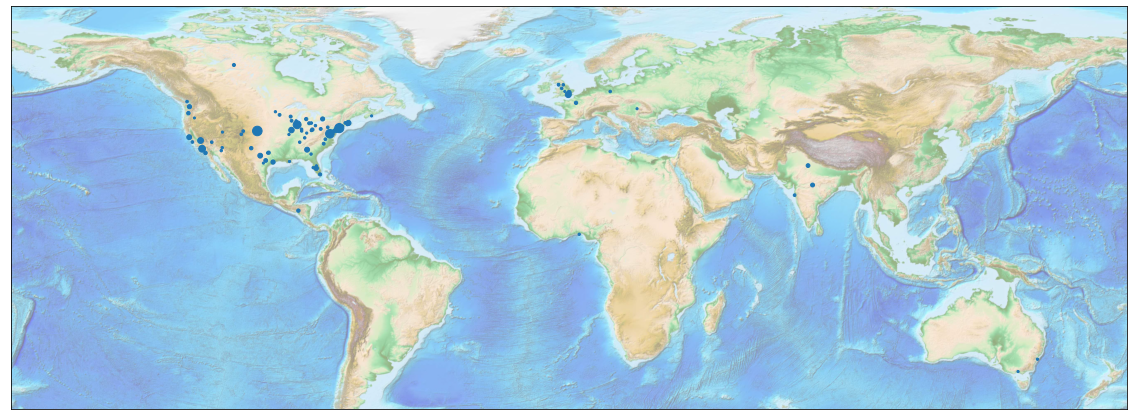

In [120]:
plotLatLon(uChiDF)

### Yale University

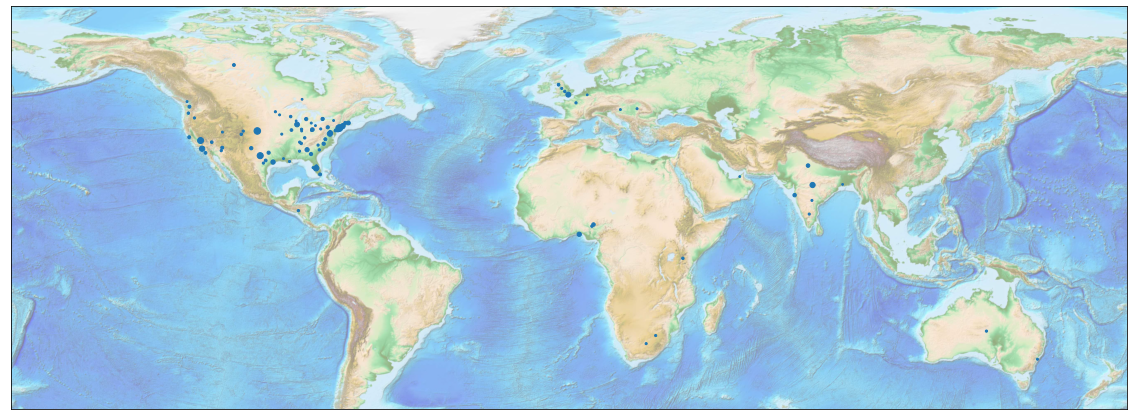

In [127]:
yaleDF["location"]=yaleDF["location"].str.lower()
yaleDF=yaleDF[yaleDF['location']!='none']
plotLatLon(yaleDF)

### Florida State University

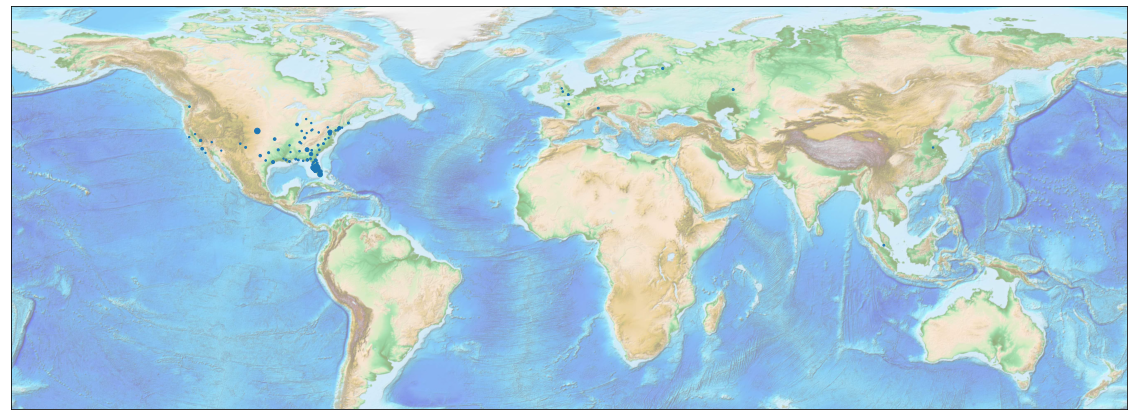

In [79]:
fsuDF["location"]=fsuDF["location"].str.lower()
fsuDF=fsuDF[fsuDF['location']!='none']
plotLatLon(fsuDF)

### University of Florida

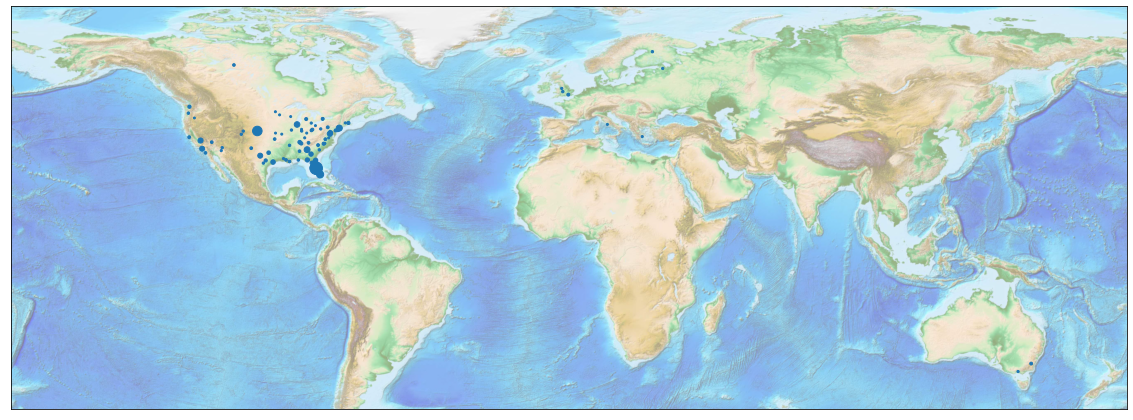

In [130]:
UFDF["location"]=UFDF["location"].str.lower()
UFDF=UFDF[UFDF['location']!='none']
plotLatLon(UFDF)

## What distinguishes University of Chicago Twitterers vs Twitterers who tweet about other universities
- make visualization

In [163]:
uChiDF.columns

Index(['Unnamed: 0', 'created_at', 'favorite_count', 'favorited',
       'filter_level', 'id', 'is_quote_status', 'lang', 'quote_count',
       'reply_count', 'retweet_count', 'retweeted', 'text2', 'followers',
       'location', 'following', 'total_tweets', 'uni_tweet_count', 'uni'],
      dtype='object')

In [191]:
uChiDF['uni']='UChicago'
yaleDF['uni']='Yale'
UFDF['uni']='UF'
fsuDF['uni']='FSU'
newDF1=pd.concat([uChiDF,yaleDF])
newDf2=pd.concat([newDF1,UFDF])
newDf3=pd.concat([newDf2,fsuDF])

In [196]:
uniDF=newDf3.groupby('uni').median()

In [160]:
uniDF.columns

Index(['favorite_count', 'id', 'quote_count', 'reply_count', 'retweet_count',
       'followers', 'total_tweets', 'uni_tweet_count'],
      dtype='object')

In [197]:
uniDF=uniDF[['followers', 'total_tweets', 'uni_tweet_count']].reset_index()
uniDF

uni  followers  total_tweets  uni_tweet_count
0       FSU      427.0        8849.0                1
1  UChicago      469.0        8568.0                1
2        UF      444.0       11518.0                1
3      Yale      435.0       11533.0                1

In [173]:
uniDF.columns

Index(['uni', 'followers', 'total_tweets', 'uni_tweet_count'], dtype='object')

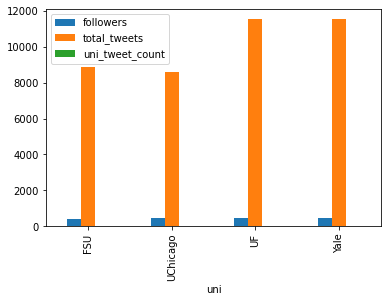

In [198]:
uniDF.plot('uni',[1,2,3],kind = 'bar')

It looks like Uchicago has the highest amount of median followers and the lowest amount of total_tweets. This would suggest to me that they have a very good tweet to follower ratio but could possibly increase the amount of tweets per user to get a better influence ranking.

## What are the timelines of these tweets? Do you see significant peaks and valleys?
- Do you see data collection gaps?

### University of Chicago

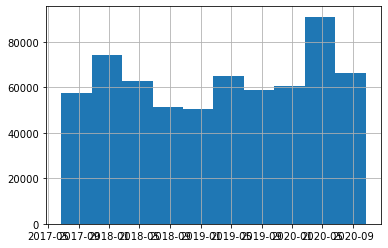

In [15]:
chiDT=pd.to_datetime(uChiDF['created_at'])
chiDT.hist()

### Yale University

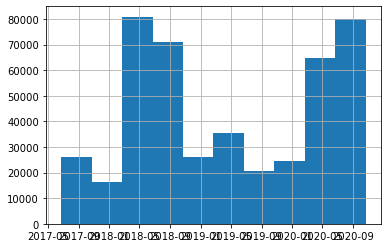

In [16]:
yaleDT=pd.to_datetime(yaleDF['created_at'])
yaleDT.hist()

### Florida State University

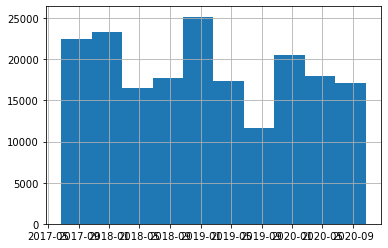

In [134]:
fsuDT=pd.to_datetime(fsuDF['created_at'])
fsuDT.hist()

### University of Florida

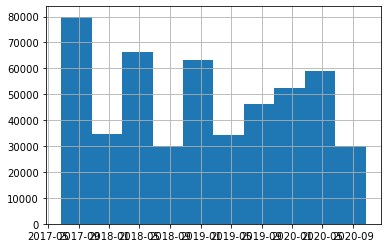

In [17]:
ufDT=pd.to_datetime(UFDF['created_at'])
ufDT.hist()

## How unique are the messages for each of these universities?
- Are they mostly unique? Or mostly people are just copy-pasting the same text?
- You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
- Visualize message duplication (for each university – not between the universities)
- Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis.

In [63]:
def get_features(s):
    width = 5
    try:
        s = s.lower()#makes string lowercase
    except:
        print(s)
    s = re.sub(r'[^\w]+', '', s)#removes spaces and non letter characters
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]#splits the letters up in intervals of 3 as shown below

In [52]:
def simHashBarPlot(df):
    dat=df['text2'].to_dict()
    data_first = {k: dat[k] for k in list(dat)[:5]}
    objs = [(str(k), Simhash(get_features(v))) for k, v in dat.items()]
    index = SimhashIndex(objs, k=3)
    
    dups=[]
    for i,j in dat.items():
        s=Simhash(get_features(j))
        ind=index.get_near_dups(s)
        dups.append([i,j,len(ind)-1,ind])#get key, value amount of duplicates and index of duplicates
    dupDF=pd.DataFrame(dups,columns=['index','title','amountDuplicates','index of duplicates'])
    isDuplicated=[]
    for i in dupDF['amountDuplicates']:
        if i==0:
            isDuplicated.append(0)
        else:
            isDuplicated.append(1)
    dupDF['isDuplicated']=isDuplicated
    counts=dupDF['isDuplicated'].value_counts()
    counts.plot(kind='bar')
    plt.xlabel("Count of Near Duplicated(1) vs. Count of Unique(0)", labelpad=14)

In [ ]:
def simHashDensPlot(df)
isDupDF=dupDF.where(dupDF['isDuplicated']==1).dropna()
isDupDF=isDupDF.reset_index()
isDupDF['index']=isDupDF.index
isDupDF.head()

sns.distplot(isDupDF['amountDuplicates'])

### University of Chicago

Big bucket found. key:ebc6:0, len:1018
Big bucket found. key:4141:1, len:1017
Big bucket found. key:5485:2, len:1016
Big bucket found. key:6da0:3, len:1016
Big bucket found. key:62d1:0, len:326
Big bucket found. key:4b0a:1, len:328
Big bucket found. key:88e3:2, len:326
Big bucket found. key:68a1:3, len:327
Big bucket found. key:ebc6:0, len:1018
Big bucket found. key:4141:1, len:1017
Big bucket found. key:5485:2, len:1016
Big bucket found. key:6da0:3, len:1016
Big bucket found. key:62d1:0, len:326
Big bucket found. key:4b0a:1, len:328
Big bucket found. key:88e3:2, len:326
Big bucket found. key:68a1:3, len:327
Big bucket found. key:ebc6:0, len:1018
Big bucket found. key:4141:1, len:1017
Big bucket found. key:5485:2, len:1016
Big bucket found. key:6da0:3, len:1016
Big bucket found. key:ebc6:0, len:1018
Big bucket found. key:4141:1, len:1017
Big bucket found. key:5485:2, len:1016
Big bucket found. key:6da0:3, len:1016
Big bucket found. key:70bb:0, len:270
Big bucket found. key:e4ad:1, len:

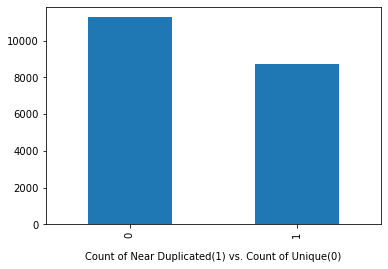

In [80]:
chiSubset=uChiDF.sample(n=20000)
simHashBarPlot(chiSubset)

### Yale University

Big bucket found. key:b888:0, len:791
Big bucket found. key:cc90:1, len:791
Big bucket found. key:ccf8:2, len:791
Big bucket found. key:e6cd:3, len:791
Big bucket found. key:39a:0, len:1038
Big bucket found. key:6d0b:1, len:1038
Big bucket found. key:84f:2, len:1039
Big bucket found. key:d1a0:3, len:1040
Big bucket found. key:b888:0, len:791
Big bucket found. key:cc90:1, len:791
Big bucket found. key:ccf8:2, len:791
Big bucket found. key:e6cd:3, len:791
Big bucket found. key:30ed:0, len:1074
Big bucket found. key:808b:1, len:1076
Big bucket found. key:5828:2, len:1074
Big bucket found. key:ca2d:3, len:1104
Big bucket found. key:b888:0, len:791
Big bucket found. key:cc90:1, len:791
Big bucket found. key:ccf8:2, len:791
Big bucket found. key:e6cd:3, len:791
Big bucket found. key:30ed:0, len:1074
Big bucket found. key:808b:1, len:1076
Big bucket found. key:5828:2, len:1074
Big bucket found. key:ca2d:3, len:1104
Big bucket found. key:39a:0, len:1038
Big bucket found. key:6d0b:1, len:1038
B

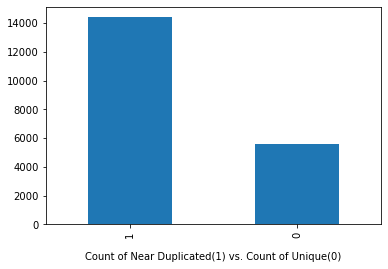

In [55]:
yaleSubset=yaleDF.sample(n=20000)
simHashBarPlot(yaleSubset)

### Florida State University

Big bucket found. key:5848:0, len:779
Big bucket found. key:62e8:1, len:778
Big bucket found. key:acc8:2, len:778
Big bucket found. key:c3a2:3, len:778
Big bucket found. key:f3bc:0, len:395
Big bucket found. key:840e:1, len:402
Big bucket found. key:4cb8:2, len:410
Big bucket found. key:81e0:3, len:400
Big bucket found. key:f3bc:0, len:395
Big bucket found. key:840e:1, len:402
Big bucket found. key:4cb8:2, len:410
Big bucket found. key:81e0:3, len:400
Big bucket found. key:5848:0, len:779
Big bucket found. key:62e8:1, len:778
Big bucket found. key:acc8:2, len:778
Big bucket found. key:c3a2:3, len:778
Big bucket found. key:f3bc:0, len:395
Big bucket found. key:840e:1, len:402
Big bucket found. key:4cb8:2, len:410
Big bucket found. key:81e0:3, len:400
Big bucket found. key:5848:0, len:779
Big bucket found. key:62e8:1, len:778
Big bucket found. key:acc8:2, len:778
Big bucket found. key:c3a2:3, len:778
Big bucket found. key:5848:0, len:779
Big bucket found. key:62e8:1, len:778
Big bucket f

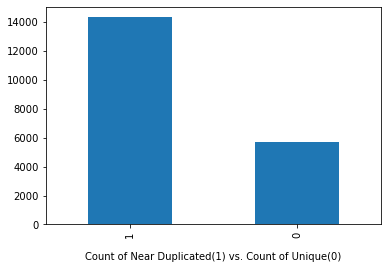

In [56]:
fsuSubset=fsuDF.sample(n=20000)
simHashBarPlot(fsuSubset)

### University of Florida

In [73]:
ufDF=ufDF[ufDF['text2'].notnull()]

Big bucket found. key:4a23:0, len:695
Big bucket found. key:a369:1, len:694
Big bucket found. key:d383:2, len:694
Big bucket found. key:2b24:3, len:718
Big bucket found. key:7a06:0, len:661
Big bucket found. key:a0ac:1, len:658
Big bucket found. key:a098:2, len:658
Big bucket found. key:4b6:3, len:658
Big bucket found. key:4a23:0, len:695
Big bucket found. key:a369:1, len:694
Big bucket found. key:d383:2, len:694
Big bucket found. key:2b24:3, len:718
Big bucket found. key:4a23:0, len:695
Big bucket found. key:a369:1, len:694
Big bucket found. key:d383:2, len:694
Big bucket found. key:2b24:3, len:718
Big bucket found. key:367e:0, len:355
Big bucket found. key:830f:1, len:354
Big bucket found. key:e8c1:2, len:353
Big bucket found. key:86e6:3, len:354
Big bucket found. key:f2e6:0, len:265
Big bucket found. key:8c62:1, len:265
Big bucket found. key:a38b:2, len:266
Big bucket found. key:88ab:3, len:265
Big bucket found. key:367e:0, len:355
Big bucket found. key:830f:1, len:354
Big bucket fo

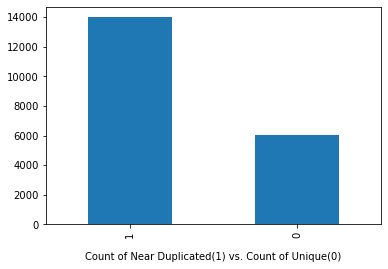

In [74]:
#ufDF=ufDF[ufDF['text2']!='nan']
ufSubset=UFDF.sample(n=20000)
simHashBarPlot(ufSubset)